In [ ]:
import sys
!{sys.executable} -m pip install aequitas==0.42 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 5.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
visions 0.7.6 requires pandas>=2.0.0, but you have pandas 1.2.3 which is incompatible.


In [18]:
import pandas as pd
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
# import aequitas.plot as ap
from aequitas.plotting import Plot
ap = Plot()

# Enable Pandas to display dataframes without restriction.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Load in the data and take an initial look at it.
#***score: model prediction
#***label: truth label
df = pd.read_csv("compas_for_aequitas.csv")
print(df.shape)
df.head()

(7214, 6)


,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [4]:
# Race is our protected class that we will be exploring.
df["race"].value_counts()

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

In [5]:
# Remove the races that have very little data in this data.
df = df[~df["race"].isin(["Asian", "Native American"])]

### Create Crosstab

Create the crosstab that forms the basis for all the subsequent analyses.

In [6]:
group = Group()
xtab, _ = group.get_crosstabs(df)

xtab.head(10)

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,3297,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.659387,0.588203,805,532,990,1369,1901,1795,3696,7164,0.514340
1,0,binary 0/1,3297,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.259023,0.348003,349,461,1139,505,966,1488,2454,7164,0.393643
2,0,binary 0/1,3297,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057628,0.298273,87,129,318,103,232,405,637,7164,0.364207
3,0,binary 0/1,3297,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023961,0.209549,36,90,208,43,133,244,377,7164,0.352785
4,0,binary 0/1,3297,sex,Female,0.607287,0.678212,0.242197,0.489796,0.321788,0.392713,0.757803,0.510204,588,801,0.178344,0.423326,288,194,607,300,494,895,1389,7164,0.355652
5,0,binary 0/1,3297,sex,Male,0.628196,0.674350,0.332029,0.365079,0.325650,0.371804,0.667971,0.634921,2709,3066,0.821656,0.469091,989,1018,2048,1720,2738,3037,5775,7164,0.474113
6,0,binary 0/1,3297,age_cat,25 - 45,0.625399,0.665607,0.324885,0.384736,0.334393,0.374601,0.675115,0.615264,1913,2170,0.580224,0.468528,736,705,1465,1177,1882,2201,4083,7164,0.460936
7,0,binary 0/1,3297,age_cat,Greater than 45,0.424797,0.830841,0.241468,0.464103,0.169159,0.575203,0.758532,0.535897,390,1172,0.118289,0.249680,181,283,889,209,492,1070,1562,7164,0.314981
8,0,binary 0/1,3297,age_cat,Less than 25,0.738928,0.455371,0.426667,0.362173,0.544629,0.261072,0.573333,0.637827,994,525,0.301486,0.654378,360,224,301,634,858,661,1519,7164,0.564845


Abbev. | Name
--- | ---
tpr | True Positive Rate
tnr | True Negative Rate
for |False Omission Rate
fdr | False Discovery Rate
fpr | False Positive Rate
fnr | False Negative Rate
npv | Negative Predictive Value
pp | Predicted Positive Count
pn | Predicted Negative Count
ppr | Predicted Positive Ratio_k
pprev | Predicted Positive Ratio_g
fp | False Postives
fn | False Negatives
tn | True Negatives
tp | True Positives
prev | Group Prevalance

### Compute Bias

We calculate the bias vs. a predefined group we manually set.

In [7]:
bias = Bias()
bias_df = bias.get_disparity_predefined_groups(xtab,
                                               original_df=df,
                                               ref_groups_dict={"race": "Caucasian", "sex": "Male", "age_cat": "25 - 45"},
                                               alpha=0.05,
                                               mask_significance=True)
bias_df.head(10)

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,3297,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.659387,0.588203,805,532,990,1369,1901,1795,3696,7164,0.514340,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
1,0,binary 0/1,3297,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.259023,0.348003,349,461,1139,505,966,1488,2454,7164,0.393643,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
2,0,binary 0/1,3297,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057628,0.298273,87,129,318,103,232,405,637,7164,0.364207,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,binary 0/1,3297,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023961,0.209549,36,90,208,43,133,244,377,7164,0.352785,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,binary 0/1,3297,sex,Female,0.607287,0.678212,0.242197,0.489796,0.321788,0.392713,0.757803,0.510204,588,801,0.178344,0.423326,288,194,607,300,494,895,1389,7164,0.355652,0.217054,0.902439,0.803571,1.341615,0.729447,0.988139,1.056235,0.966717,1.005728,1.134484,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
5,0,binary 0/1,3297,sex,Male,0.628196,0.674350,0.332029,0.365079,0.325650,0.371804,0.667971,0.634921,2709,3066,0.821656,0.469091,989,1018,2048,1720,2738,3037,5775,7164,0.474113,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
6,0,binary 0/1,3297,age_cat,25 - 45,0.625399,0.665607,0.324885,0.384736,0.334393,0.374601,0.675115,0.615264,1913,2170,0.580224,0.468528,736,705,1465,1177,1882,2201,4083,7164,0.460936,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45
7,0,binary 0/1,3297,age_cat,Greater than 45,0.424797,0.830841,0.241468,0.464103,0.169159,0.575203,0.758532,0.535897,390,1172,0.118289,0.249680,181,283,889,209,492,1070,1562,7164,0.314981,0.203868,0.532903,0.871004,1.206288,0.743241,0.505868,1.535507,0.679242,1.248247,1.123560,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45
8,0,binary 0/1,3297,age_cat,Less than 25,0.738928,0.455371,0.426667,0.362173,0.544629,0.261072,0.573333,0.637827,994,525,0.301486,0.654378,360,224,301,634,858,661,1519,7164,0.564845,0.519603,1.396667,1.036672,0.941355,1.313286,1.628708,0.696933,1.181531,0.684144,0.849238,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45


Another common option:

In [8]:
bias.get_disparity_major_group(xtab,
                               original_df=df,
                               alpha=0.05,
                               mask_significance=True).head(10)

get_disparity_major_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,3297,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.659387,0.588203,805,532,990,1369,1901,1795,3696,7164,0.514340,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American
1,0,binary 0/1,3297,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.259023,0.348003,349,461,1139,505,966,1488,2454,7164,0.393643,0.392824,0.591638,0.939052,1.103650,0.824297,0.522987,1.705274,0.725927,1.387874,1.094418,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American
2,0,binary 0/1,3297,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057628,0.298273,87,129,318,103,232,405,637,7164,0.364207,0.087397,0.507092,0.860874,1.236600,0.825630,0.478997,1.986883,0.616493,1.423644,1.093702,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American
3,0,binary 0/1,3297,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023961,0.209549,36,90,208,43,133,244,377,7164,0.352785,0.036339,0.356253,0.864366,1.230663,0.864031,0.328989,2.418028,0.448947,1.545620,1.073066,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American
4,0,binary 0/1,3297,sex,Female,0.607287,0.678212,0.242197,0.489796,0.321788,0.392713,0.757803,0.510204,588,801,0.178344,0.423326,288,194,607,300,494,895,1389,7164,0.355652,0.217054,0.902439,0.803571,1.341615,0.729447,0.988139,1.056235,0.966717,1.005728,1.134484,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
5,0,binary 0/1,3297,sex,Male,0.628196,0.674350,0.332029,0.365079,0.325650,0.371804,0.667971,0.634921,2709,3066,0.821656,0.469091,989,1018,2048,1720,2738,3037,5775,7164,0.474113,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
6,0,binary 0/1,3297,age_cat,25 - 45,0.625399,0.665607,0.324885,0.384736,0.334393,0.374601,0.675115,0.615264,1913,2170,0.580224,0.468528,736,705,1465,1177,1882,2201,4083,7164,0.460936,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45
7,0,binary 0/1,3297,age_cat,Greater than 45,0.424797,0.830841,0.241468,0.464103,0.169159,0.575203,0.758532,0.535897,390,1172,0.118289,0.249680,181,283,889,209,492,1070,1562,7164,0.314981,0.203868,0.532903,0.871004,1.206288,0.743241,0.505868,1.535507,0.679242,1.248247,1.123560,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45
8,0,binary 0/1,3297,age_cat,Less than 25,0.738928,0.455371,0.426667,0.362173,0.544629,0.261072,0.573333,0.637827,994,525,0.301486,0.654378,360,224,301,634,858,661,1519,7164,0.564845,0.519603,1.396667,1.036672,0.941355,1.313286,1.628708,0.696933,1.181531,0.684144,0.849238,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45


In [9]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)
fairness_df.head(10)

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,3297,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.659387,0.588203,805,532,990,1369,1901,1795,3696,7164,0.514340,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False
1,0,binary 0/1,3297,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.259023,0.348003,349,461,1139,505,966,1488,2454,7164,0.393643,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,0,binary 0/1,3297,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057628,0.298273,87,129,318,103,232,405,637,7164,0.364207,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
3,0,binary 0/1,3297,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023961,0.209549,36,90,208,43,133,244,377,7164,0.352785,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,True,True,True,False,False,False,False,False
4,0,binary 0/1,3297,sex,Female,0.607287,0.678212,0.242197,0.489796,0.321788,0.392713,0.757803,0.510204,588,801,0.178344,0.423326,288,194,607,300,494,895,1389,7164,0.355652,0.217054,0.902439,0.803571,1.341615,0.729447,0.988139,1.056235,0.966717,1.005728,1.134484,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False
5,0,binary 0/1,3297,sex,Male,0.628196,0.674350,0.332029,0.365079,0.325650,0.371804,0.667971,0.634921,2709,3066,0.821656,0.469091,989,1018,2048,1720,2738,3037,5775,7164,0.474113,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
6,0,binary 0/1,3297,age_cat,25 - 45,0.625399,0.665607,0.324885,0.384736,0.334393,0.374601,0.675115,0.615264,1913,2170,0.580224,0.468528,736,705,1465,1177,1882,2201,4083,7164,0.460936,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,0,binary 0/1,3297,age_cat,Greater than 45,0.424797,0.830841,0.241468,0.464103,0.169159,0.575203,0.758532,0.535897,390,1172,0.118289,0.249680,181,283,889,209,492,1070,1562,7164,0.314981,0.203868,0.532903,0.871004,1.206288,0.743241,0.505868,

In [10]:
overall_fairness = fairness.get_overall_fairness(fairness_df)
print(overall_fairness)

{'Unsupervised Fairness': False, 'Supervised Fairness': False, 'Overall Fairness': False}


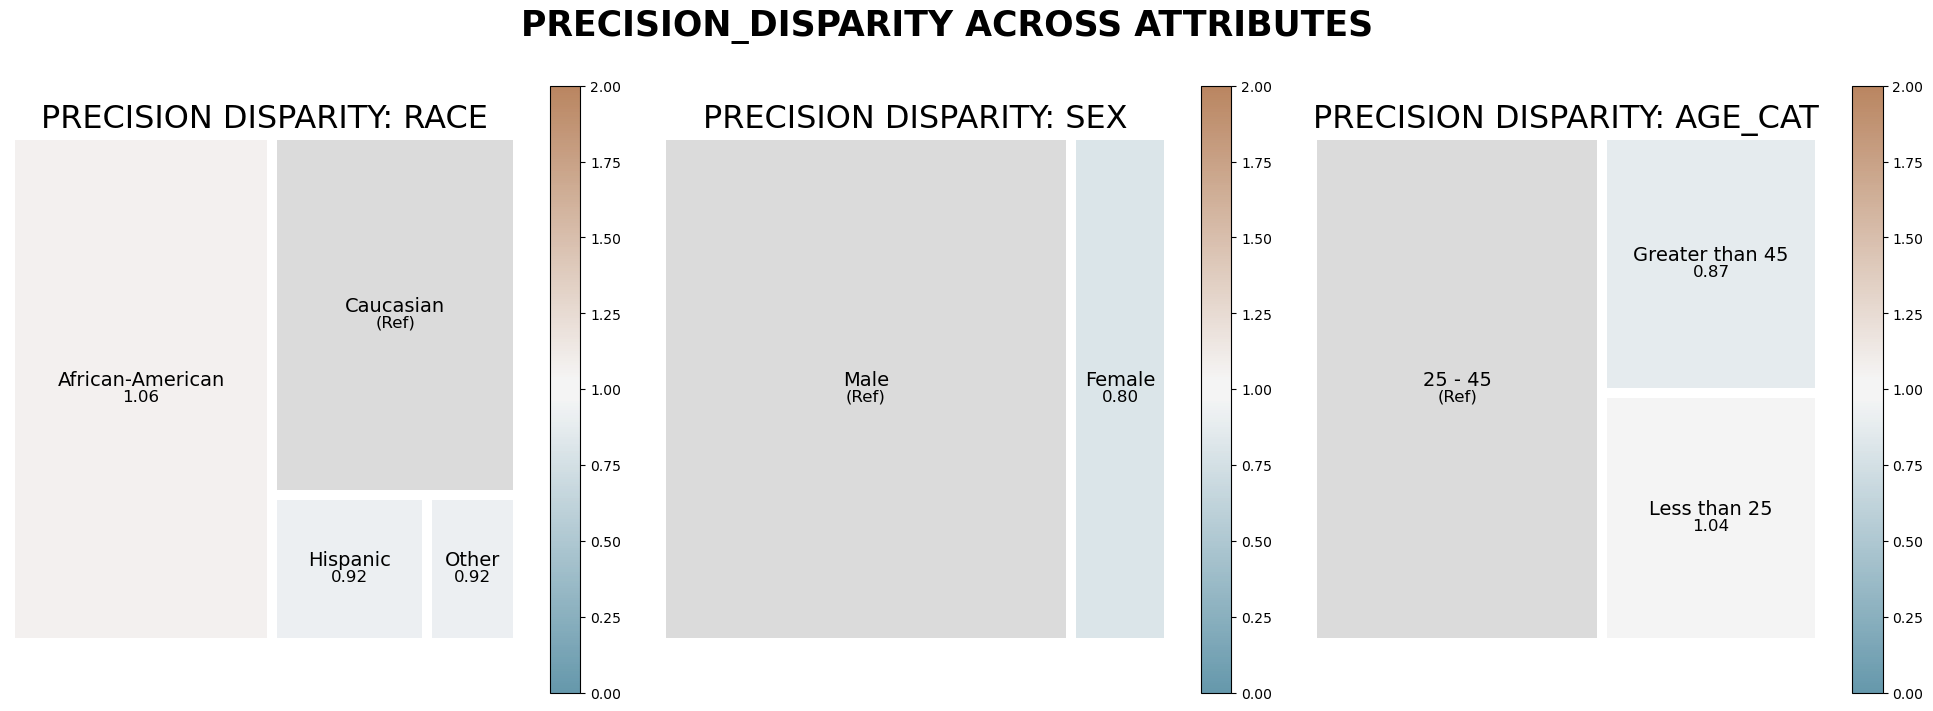

In [ ]:
# Precision disparity: refers to differences in precision across different groups within a dataset,
disparity_tolerance = 1.25
p = ap.plot_disparity_all(bias_df, metrics=['precision_disparity'], significance_alpha=0.05)
